# [Data Dictionary](http://kdd.ics.uci.edu/databases/kddcup99/task.html)
# 

In [19]:
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score

In [2]:
train_attack_types = pd.read_csv("datasets/training_attack_types.txt", delimiter=" ", header=None, names= ["attack_type", "attack_category"])

In [3]:
target = "back"
train_attack_types.loc[train_attack_types["attack_type"]==target, "attack_category"].values[0]

'dos'

In [4]:
cols = list(pd.read_csv("datasets/kddcup.names.txt", skiprows=1, header=None)[0].map(lambda x: str(x).split(":")[0]).values)
cols.append("label")
cols

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'label']

In [5]:
train = pd.read_csv("datasets/kddcup.data.corrected.txt", header=None, names=cols)

In [6]:
test = pd.read_csv("datasets/corrected.txt", header=None, names=cols)

In [7]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [8]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


# EDA

## Process the label column
We want to remove the period. Then we want to generate three label columns:

In [9]:
train["label"] = train["label"].map(lambda x: x.split(".")[0])
test["label"] = test["label"].map(lambda x: x.split(".")[0])

### Binary label (normal/malicious)

In [10]:
train["label_binary"] = train["label"].map(lambda x: 0 if x=="normal" else 1)
test["label_binary"] = test["label"].map(lambda x: 0 if x=="normal" else 1)

In [11]:
test["label_binary"].value_counts()

1    250436
0     60593
Name: label_binary, dtype: int64

In [12]:
train["label_binary"].value_counts()

1    3925650
0     972781
Name: label_binary, dtype: int64

### Coarse multiclass label (normal, probe, u2r, r2l, dos)

In [13]:
train_attack_types

,attack_type,attack_category
0,back,dos
1,buffer_overflow,u2r
2,ftp_write,r2l
3,guess_passwd,r2l
4,imap,r2l
5,ipsweep,probe
6,land,dos
7,loadmodule,u2r
8,multihop,r2l
9,neptune,dos


In [14]:
attack_dict_coarse = {
    i:j for i,j in zip(train_attack_types["attack_type"], train_attack_types["attack_category"])
} 
attack_dict_coarse["normal"] = "normal"

In [15]:
train["label_coarse"] = train["label"].map(attack_dict_coarse).map({
    "normal":0,
    "dos": 1,
    "probe": 2,
    "r2l": 3,
    "u2r": 4
})

In [16]:
train["label_coarse"].value_counts()

1    3883370
0     972781
2      41102
3       1126
4         52
Name: label_coarse, dtype: int64

In [17]:
test["label_coarse"] = test["label"].map(attack_dict_coarse).map({
    "normal":0,
    "dos": 1,
    "probe": 2,
    "r2l": 3,
    "u2r": 4
})
test["label_coarse"].value_counts()

1.0    223298
0.0     60593
3.0      5993
2.0      2377
4.0        39
Name: label_coarse, dtype: int64

### Fine-grained multiclass label (all).

In [21]:
test["label"].value_counts()

smurf              164091
normal              60593
neptune             58001
snmpgetattack        7741
mailbomb             5000
guess_passwd         4367
snmpguess            2406
satan                1633
warezmaster          1602
back                 1098
mscan                1053
apache2               794
processtable          759
saint                 736
portsweep             354
ipsweep               306
httptunnel            158
pod                    87
nmap                   84
buffer_overflow        22
multihop               18
sendmail               17
named                  17
ps                     16
rootkit                13
xterm                  13
teardrop               12
xlock                   9
land                    9
xsnoop                  4
ftp_write               3
perl                    2
loadmodule              2
sqlattack               2
phf                     2
udpstorm                2
worm                    2
imap                    1
Name: label,

In [20]:
test["label_coarse"]

0         0.0
1         0.0
2         0.0
3         NaN
4         NaN
         ... 
311024    0.0
311025    0.0
311026    0.0
311027    0.0
311028    0.0
Name: label_coarse, Length: 311029, dtype: float64

In [21]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label_binary,label_coarse
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,...,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,4.834243e+01,1.834621e+03,1.093623e+03,5.716116e-06,6.487792e-04,7.961733e-06,1.243766e-02,3.205108e-05,1.435290e-01,8.088304e-03,...,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02,8.014097e-01,8.102921e-01
std,7.233298e+02,9.414311e+05,6.450123e+05,2.390833e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506116e-01,3.856481e+00,...,4.111860e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821774e-01,2.309428e-01,2.309777e-01,3.989389e-01,4.147374e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,5.832900e+04,1.379964e+09,1.309937e+09,1.000000e+00,3.000000e+00,1.400000e+01,7.700000e+01,5.000000e+00,1.000000e+00,7.479000e+03,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [22]:
X = pd.get_dummies(train, columns=["protocol_type", "service", "flag"], drop_first=True).drop(columns=["label", "label_binary", "label_coarse"])

# Logistic Regression
Our baseline model will always be logistic regression. Our dataset is far too large to train in any reasonable amount of time, so we'll have a larger test holdout than normal.

In [23]:
y = train["label_binary"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99)

In [25]:
X_train.shape

(48984, 119)

In [26]:
y_train.shape

(48984,)

In [27]:
logreg = LogisticRegression(penalty="none", solver="sag", max_iter=10000, verbose=1, n_jobs = -2)
logreg.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 3881 epochs took 246 seconds


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:  4.1min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=-2, penalty='none',
                   random_state=None, solver='sag', tol=0.0001, verbose=1,
                   warm_start=False)

In [28]:
logreg.score(X_train, y_train)

0.9517189286297566

In [29]:
logreg.score(X_test, y_test)

0.9517848117527627

In [30]:
roc_auc_score(y_train, logreg.predict(X_train))

0.8809953016736294

In [31]:
roc_auc_score(y_test, logreg.predict(X_test))

0.8813256178102143

In [ ]:
# cross_val_score(logreg, X_train, y_train)

In [32]:
y_actual = test["label"].map(lambda x: 0 if x == "normal" else 1)
y_actual

0         0
1         0
2         0
3         1
4         1
         ..
311024    0
311025    0
311026    0
311027    0
311028    0
Name: label, Length: 311029, dtype: int64

In [33]:
X_big_test = pd.get_dummies(test, columns=["protocol_type", "service", "flag"], drop_first=True).drop(columns=["label", "label_binary"])

In [34]:
X_big_test.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=115)

In [35]:
X_test.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=119)

In [36]:
cols_to_zero = [col for col in X_test.columns if col not in X_big_test.columns]
for col in cols_to_zero:
    X_big_test[col] = 0

In [37]:
logreg.score(X_big_test[X_test.columns], y_actual)

0.9134100035687991

In [38]:
roc_auc_score(y_actual, logreg.predict(X_big_test[X_test.columns]))

0.8310892010331374

In [37]:
tn, fp, fn, tp = confusion_matrix(logreg.predict(X_big_test[X_test.columns]), y_actual).ravel()

In [38]:
# Our sensitivity is
(tp) / (tp + fn) 

0.9185488755048431

In [39]:
# Our precision is
(tp) / (tp + fp)

0.9871623887939434

In [49]:
coefs = pd.DataFrame(logreg.coef_, columns=X_test.columns, index=["coef_"]).T

In [56]:
with pd.option_context("max_rows", None):
    display(coefs.sort_values(by="coef_", ascending=False))

,coef_
count,2.389644e-03
srv_count,1.842836e-03
dst_host_count,1.306798e-03
dst_host_srv_count,4.859674e-04
service_ecr_i,3.619133e-06
dst_host_same_src_port_rate,3.334232e-06
service_private,2.584658e-06
serror_rate,2.449654e-06
dst_host_srv_serror_rate,2.448911e-06
dst_host_serror_rate,2.447952e-06


## restricted features


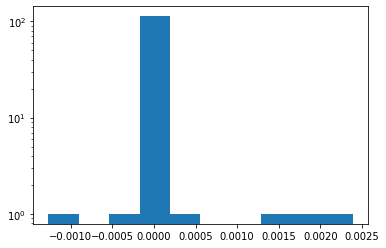

In [62]:
plt.hist(logreg.coef_[0]);
plt.yscale('log')

In [61]:
logreg.coef_

array([[-3.04870687e-04, -4.06842695e-07, -1.27168903e-03,
         7.11492292e-10,  1.26544826e-08, -3.03571945e-13,
         3.97804285e-08, -3.68538854e-10, -1.48680640e-06,
         8.38451803e-09,  7.16720700e-10, -6.07143891e-13,
        -6.35036449e-08, -1.05630183e-08, -1.18241615e-09,
        -6.88331550e-09,  0.00000000e+00,  0.00000000e+00,
        -5.42029909e-09,  2.38964391e-03,  1.84283565e-03,
         2.44965448e-06,  2.44779507e-06,  4.15198098e-07,
         4.18373430e-07,  1.44604396e-06,  1.75329957e-07,
        -3.23597337e-07,  1.30679802e-03,  4.85967382e-04,
         1.78521165e-06,  9.07607672e-08,  3.33423163e-06,
        -2.91254241e-08,  2.44795183e-06,  2.44891118e-06,
         4.14042803e-07,  4.24013305e-07,  1.32511891e-06,
        -7.21868507e-07, -7.31189313e-10,  3.47299565e-09,
         0.00000000e+00, -4.84498595e-09,  4.35192263e-09,
         5.07570074e-09,  2.39310882e-09,  3.39554015e-09,
         3.97816525e-09,  3.25204832e-09,  3.41722524e-0

## Only using basic metadata
It's useful to see how we do with only the first few columns:

## Residuals
Do an analysis of the resids

Maybe simulate some internal attacks on your own network. Can you connect a networking component with a model scoring component?

Online learning (iterative model updating). See "vawpol wabbit"

See

http://onlineprediction.net/?n=Main.HomePage

https://duckduckgo.com/?q=vawp`ol+wabbit&t=ffab&ia=web
    